In [1]:
#%% Imports
import os
import shutil
import nibabel as nib
import numpy as np
from glob import glob
from scipy import ndimage
from nilearn.image import resample_to_img
from nilearn.masking import compute_background_mask, compute_epi_mask
from nilearn.plotting import plot_roi

/home/uziel/miniconda2/envs/diss/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#%% Set current directory
os.chdir('/home/uziel/DISS') # linux
test_flag = 1

In [3]:
#%% List all sequences per subject
# linux
if test_flag:
    root = './data/ISLES2017/testing'
else:
    root = './data/ISLES2017/training'

subjects_paths = sorted(os.listdir(root))
channels_per_subject = dict() # groups relevant sequences per subject
for i in range(len(subjects_paths)):
    s_path = os.path.join(root, subjects_paths[i])
    channels_per_subject[i] = [y for x in os.walk(s_path) for y in
                        glob(os.path.join(x[0], '*ADC*.nii')) or
                        glob(os.path.join(x[0], '*MTT*.nii')) or
                        glob(os.path.join(x[0], '*rCBF*.nii')) or
                        glob(os.path.join(x[0], '*rCBV*.nii')) or
                        glob(os.path.join(x[0], '*Tmax*.nii')) or
                        glob(os.path.join(x[0], '*TTP*.nii')) or
                        glob(os.path.join(x[0], '*OT*.nii'))]


In [4]:
#%% Resample images to same shape and voxel size
# linux
if test_flag:
    root = './data_processed/ISLES2017/testing'
else:
    root = './data_processed/ISLES2017/training'

template_path = './data/MNI152_T1_1mm_brain.nii.gz'

# remove and create dir for processed data
if os.path.exists(root): shutil.rmtree(root)
os.makedirs(root)

# load template image
template = nib.load(template_path)

for subject in channels_per_subject.keys():
    # create subdirectory per subject
    subject_root = os.path.join(root, str(subject))
    os.mkdir(subject_root)
    
    subject_imgs = []
    for channel_file in channels_per_subject[subject]:
        img = nib.load(channel_file)
        # Resample img to match template
        resampled_img = resample_to_img(img, template)
        subject_imgs.append([resampled_img, channel_file])
        
    # compute subject brain mask given all channels (ignore label channel)
    mask = compute_epi_mask([x for x,y in subject_imgs if not "OT" in y])
    # dilate mask to "fill holes"
    dilated_mask_data = ndimage.binary_dilation(mask.dataobj)
    mask = nib.nifti1.Nifti1Image(dilated_mask_data.astype(np.int32), mask.affine)
    # save mask
    nib.save(mask, os.path.join(subject_root, 'mask.nii.gz'))
    
    # normalize each image within mask and save
    for img, channel_file in subject_imgs:
        # don't try to normalize label channel
        if "OT" not in channel_file:
            # get data within mask
            temp_data = img.dataobj * mask.dataobj
            # compute mean and variance of non-zero values
            mean = np.mean(temp_data[np.nonzero(temp_data)])
            var = np.var(temp_data[np.nonzero(temp_data)])
            # substract mean and divide by variance all non-zero valuess
            temp_data[np.nonzero(temp_data)] = (temp_data[np.nonzero(temp_data)] - mean) / var
            # build normalised image with normalised data and unmodified affine
            img = nib.nifti1.Nifti1Image(temp_data.astype(np.float32), img.affine)
        else:
            img = nib.nifti1.Nifti1Image(img.dataobj.astype(np.float32), img.affine)
        
        # save image
        file_name = os.path.basename(channel_file)
        nib.save(img, os.path.join(subject_root, file_name) + '.gz')


/home/uziel/miniconda2/envs/diss/lib/python2.7/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [5]:
def data_to_file(data, path):
    out = open(path, "w")
    for line in data:
        print >> out, line
    out.close()

In [6]:
##### FILES FOR BASELINE EXPERIMENT
#%% Generate files listing all images per channel
# linux
if test_flag:
    root = './data_processed/ISLES2017/testing'
else:
    root = './data_processed/ISLES2017/training'
    
channels = {}
# channels - sequences os.path.join('../../../../../../', x) needed for deepmedic
channels['Channels_ADC'] = [os.path.join('../../../../../../', y) for x in os.walk(root)
                            for y in glob(os.path.join(x[0], '*ADC*.nii.gz'))]
channels['Channels_MTT'] = [os.path.join('../../../../../../', y) for x in os.walk(root)
                            for y in glob(os.path.join(x[0], '*MTT*.nii.gz'))]
channels['Channels_rCBF'] = [os.path.join('../../../../../../', y) for x in os.walk(root)
                             for y in glob(os.path.join(x[0], '*rCBF*.nii.gz'))]
channels['Channels_rCBV'] = [os.path.join('../../../../../../', y) for x in os.walk(root)
                             for y in glob(os.path.join(x[0], '*rCBV*.nii.gz'))]
channels['Channels_Tmax'] = [os.path.join('../../../../../../', y) for x in os.walk(root)
                             for y in glob(os.path.join(x[0], '*Tmax*.nii.gz'))]
channels['Channels_TTP'] = [os.path.join('../../../../../../', y) for x in os.walk(root)
                            for y in glob(os.path.join(x[0], '*TTP*.nii.gz'))]
# labels
channels['GtLabels'] = [os.path.join('../../../../../../', y) for x in os.walk(root) for y in glob(os.path.join(x[0], '*OT*.nii.gz'))]
# masks
channels['RoiMasks'] = [os.path.join('../../../../../../', y) for x in os.walk(root) for y in glob(os.path.join(x[0], 'mask.nii.gz'))]

if test_flag:
    # set paths for storing channel config files
    test_path = './ischleseg/deepmedic/experiments/baseline/configFiles/test'
    if not os.path.exists(test_path): os.makedirs(test_path)
    for name, files in channels.iteritems():
        # save test channel files
        data_to_file(files, os.path.join(test_path, 'test' + name + '.cfg'))
        
    # save names of predictions
    names = ['pred_ISLES2017_' + os.path.split(os.path.dirname(x))[1] + '_nii.gz' for x in channels['Channels_ADC']]
    data_to_file(names, os.path.join(test_path, 'testNamesOfPredictions.cfg'))
else:
    # set paths for storing channel config files
    train_path = './ischleseg/deepmedic/experiments/baseline/configFiles/train'
    validation_path = './ischleseg/deepmedic/experiments/baseline/configFiles/validation'

    if not os.path.exists(train_path): os.makedirs(train_path)
    if not os.path.exists(validation_path): os.makedirs(validation_path)

    # train and validation division point
    train_val_divison = int(np.floor(len(channels['Channels_ADC']) * 0.8))

    for name, files in channels.iteritems():
        # save train channel files
        data_to_file(files[:train_val_divison], os.path.join(train_path, 'train' + name + '.cfg'))
        # save validation channel files
        data_to_file(files[train_val_divison:], os.path.join(validation_path, 'validation' + name + '.cfg'))


    # save names of predictions
    names = ['pred_ISLES2017_' + os.path.split(os.path.dirname(x))[1] + '_nii.gz' for x in channels['Channels_ADC']]
    data_to_file(names, os.path.join(validation_path, 'validationNamesOfPredictions.cfg'))


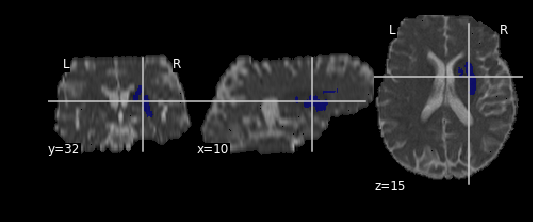

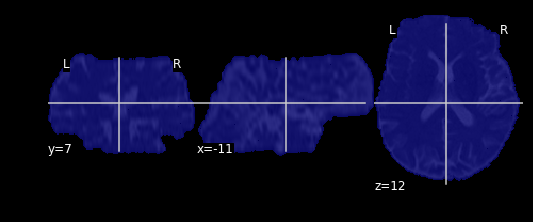

In [7]:
# load image
img = nib.load('/home/uziel/DISS/data_processed/ISLES2017/training/23/VSD.Brain.XX.O.MR_ADC.128043.nii.gz')
# load label
label = nib.load('/home/uziel/DISS/data_processed/ISLES2017/training/23/VSD.Brain.XX.O.OT.128073.nii.gz')
# plot
plot_roi(label, img)

# load mask 
mask = nib.load('/home/uziel/DISS/data_processed/ISLES2017/training/23/mask.nii.gz')
plot_roi(mask, img)

In [8]:
# load image
my_img = nib.load('/home/uziel/DISS/data_processed/ISLES2017/training/23/VSD.Brain.XX.O.MR_ADC.128043.nii.gz')
# load image
his_img = nib.load('/home/uziel/DISS/ischleseg/deepmedic/examples/dataForExamples/brats2015TrainingData/train/brats_2013_pat0005_1/Flair_subtrMeanDivStd.nii.gz')

In [9]:
# test 1
his_img = nib.load('/home/uziel/DISS/ischleseg/deepmedic/examples/dataForExamples/brats2015TrainingData/train/brats_2013_pat0005_1/Flair_subtrMeanDivStd.nii.gz')

img1 = nib.load('/home/uziel/DISS/data_processed/ISLES2017/training/23/VSD.Brain.XX.O.MR_ADC.128043.nii.gz')
img2 = nib.load('/home/uziel/DISS/data_processed/ISLES2017/training/23/VSD.Brain.XX.O.MR_rCBF.127200.nii.gz')
label = nib.load('/home/uziel/DISS/data_processed/ISLES2017/training/23/VSD.Brain.XX.O.OT.128073.nii.gz')
mask = nib.load('/home/uziel/DISS/data_processed/ISLES2017/training/23/mask.nii.gz')

In [10]:
# test 2
his_img = nib.load('/home/uziel/DISS/ischleseg/deepmedic/examples/dataForExamples/brats2015TrainingData/train/brats_2013_pat0006_1/Flair_subtrMeanDivStd.nii.gz')

img1 = nib.load('/home/uziel/DISS/data_processed/ISLES2017/training/10/VSD.Brain.XX.O.MR_ADC.128030.nii.gz')
img2 = nib.load('/home/uziel/DISS/data_processed/ISLES2017/training/10/VSD.Brain.XX.O.MR_MTT.127094.nii.gz')
label = nib.load('/home/uziel/DISS/data_processed/ISLES2017/training/10/VSD.Brain.XX.O.OT.128060.nii.gz')
mask = nib.load('/home/uziel/DISS/data_processed/ISLES2017/training/10/mask.nii.gz')

In [11]:
his_label = nib.load('/home/uziel/DISS/ischleseg/deepmedic/examples/dataForExamples/brats2015TrainingData/train/brats_2013_pat0006_1/OTMultiClass.nii.gz')
his_mask = nib.load('/home/uziel/DISS/ischleseg/deepmedic/examples/dataForExamples/brats2015TrainingData/train/brats_2013_pat0006_1/brainmask.nii.gz')

label = nib.load('/home/uziel/DISS/data_processed/ISLES2017/training/10/VSD.Brain.XX.O.OT.128060.nii.gz')
mask = nib.load('/home/uziel/DISS/data_processed/ISLES2017/training/10/mask.nii.gz')

In [12]:
for files in channels.values():
    for file in files:
        img = nib.load(file[18:])
        print(img.shape, img.get_data_dtype())

((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 218, 182), dtype('<f4'))
((182, 2